In [128]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib import style
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from pandas.plotting import autocorrelation_plot
style.use('dark_background')
import datetime
%matplotlib inline

In [129]:
df = pd.read_csv('acceleration.csv',header=1, parse_dates=['Time'], index_col='Time')
df.columns = ['acceleration']
df['acceleration'] = df['acceleration'].str.replace(' m/s²', '').astype(float)
df

,acceleration
Time,
2021-12-09 09:42:35,15.0
2021-12-09 09:43:35,15.5
2021-12-09 09:44:35,15.1
2021-12-09 09:45:35,14.7
2021-12-09 09:46:36,13.0
...,...
2022-06-09 09:37:31,14.0
2022-06-09 09:38:31,13.8
2022-06-09 09:39:31,14.6


In [130]:
df.fillna(method='backfill',inplace=True)


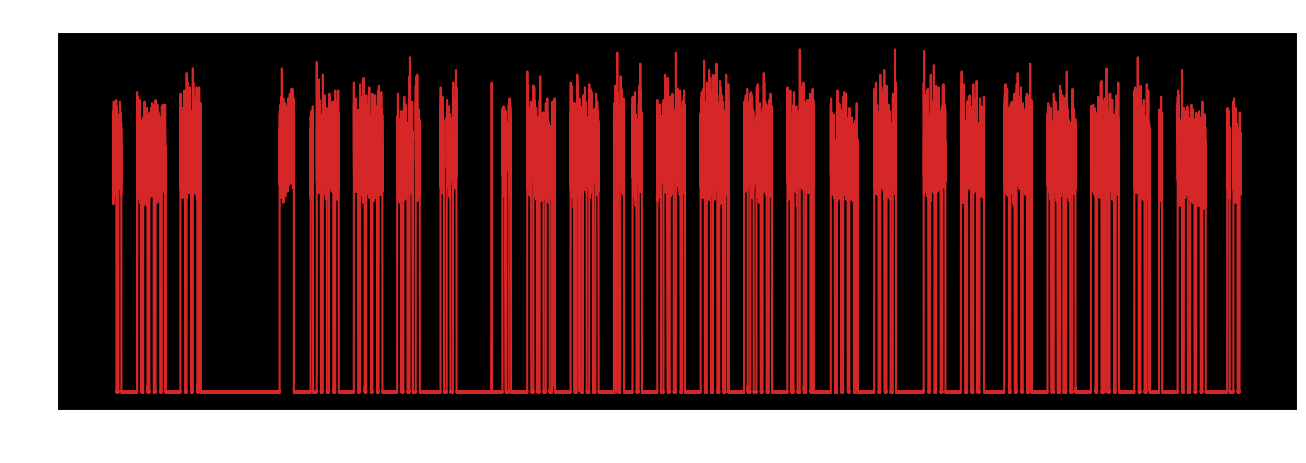

In [131]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df.index, df['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

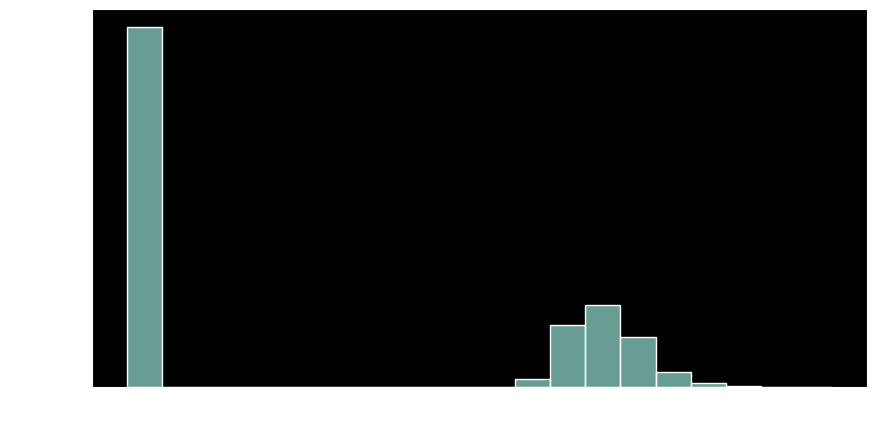

In [132]:
#Histogram with 3 standard deviations
plt.figure(figsize=(10,5), dpi=100)
# plt.hist(df['acceleration'], bins = 20
sns.histplot(df['acceleration'], bins = 20)
# plt.axvline(x=df['acceleration'].mean()+3*df['acceleration'].std(), color='red',ls= '--')
# plt.axvline(x=df['acceleration'].mean()-3*df['acceleration'].std(), color='red',ls= '--')
plt.show()

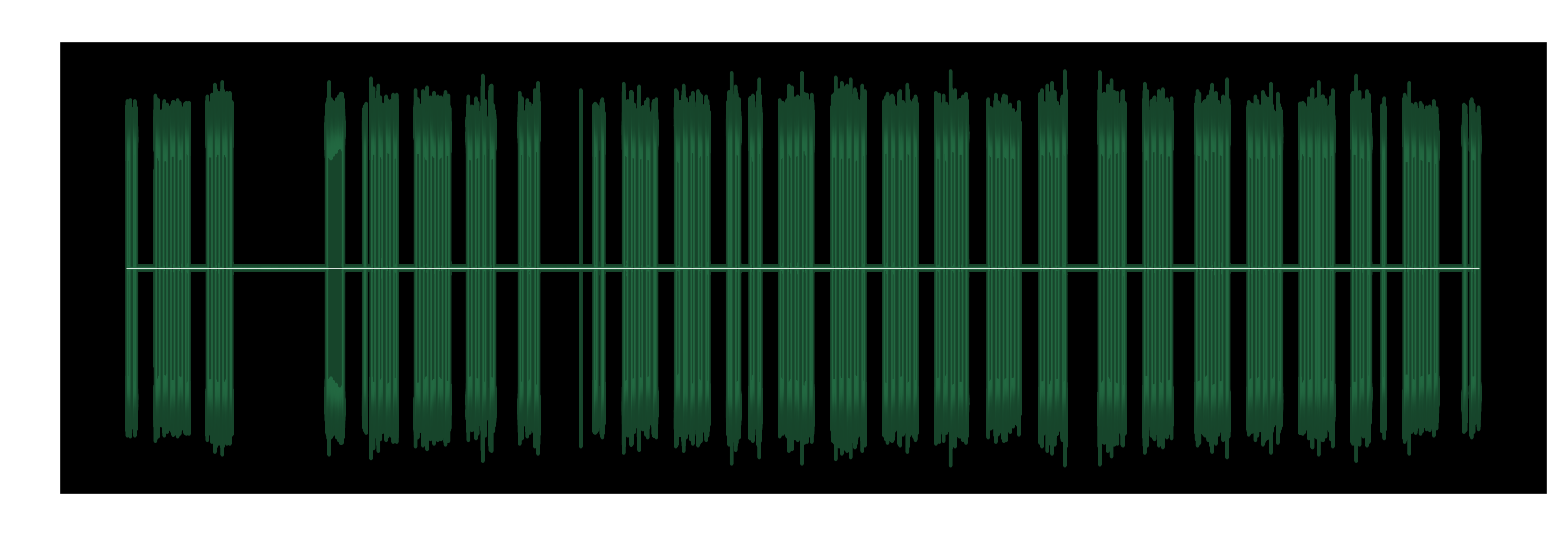

In [133]:
# Mirror axis
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(df.index, y1=df['acceleration'], y2=-df['acceleration'], alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-25, 25)
plt.title('Acceleration two side view', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

In [134]:
df_hour = df.resample('H').median()
df_hour['weekday'] = [d.strftime('%a') for d in df_hour.index]
df_hour['hour'] = [d.strftime('%H') for d in df_hour.index]
df_hour['yearweek'] = [d.strftime('%W') for d in df_hour.index]
df_hour['month'] = [d.strftime('%b') for d in df_hour.index]
df_hour['yearday'] = [d.strftime('%j') for d in df_hour.index]
df_hour['year'] = [d.strftime('%Y') for d in df_hour.index]
df_hour['hour']=df_hour['hour'].astype(int)

In [135]:
#Explore the whole series without lower values
df_hour=df_hour[df_hour['acceleration']>12]
df_hour

,acceleration,weekday,hour,yearweek,month,yearday,year
Time,,,,,,,
2021-12-09 09:00:00,14.75,Thu,9,49,Dec,343,2021
2021-12-09 10:00:00,14.20,Thu,10,49,Dec,343,2021
2021-12-09 11:00:00,14.45,Thu,11,49,Dec,343,2021
2021-12-09 12:00:00,14.25,Thu,12,49,Dec,343,2021
2021-12-09 13:00:00,14.45,Thu,13,49,Dec,343,2021
...,...,...,...,...,...,...,...
2022-06-08 21:00:00,13.85,Wed,21,23,Jun,159,2022
2022-06-09 06:00:00,14.65,Thu,6,23,Jun,160,2022
2022-06-09 07:00:00,14.40,Thu,7,23,Jun,160,2022


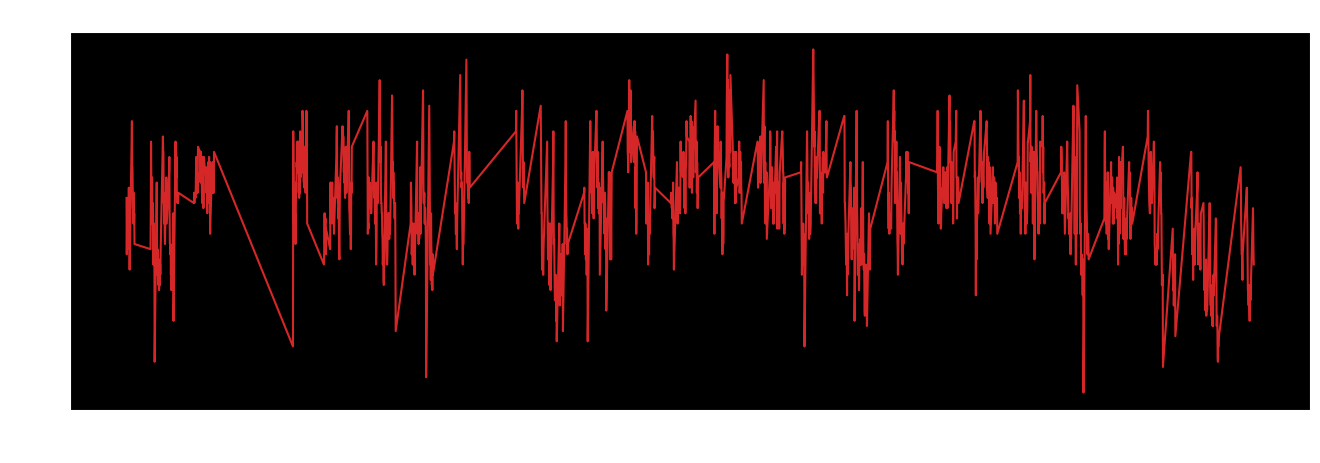

In [136]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_hour.index, df_hour['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

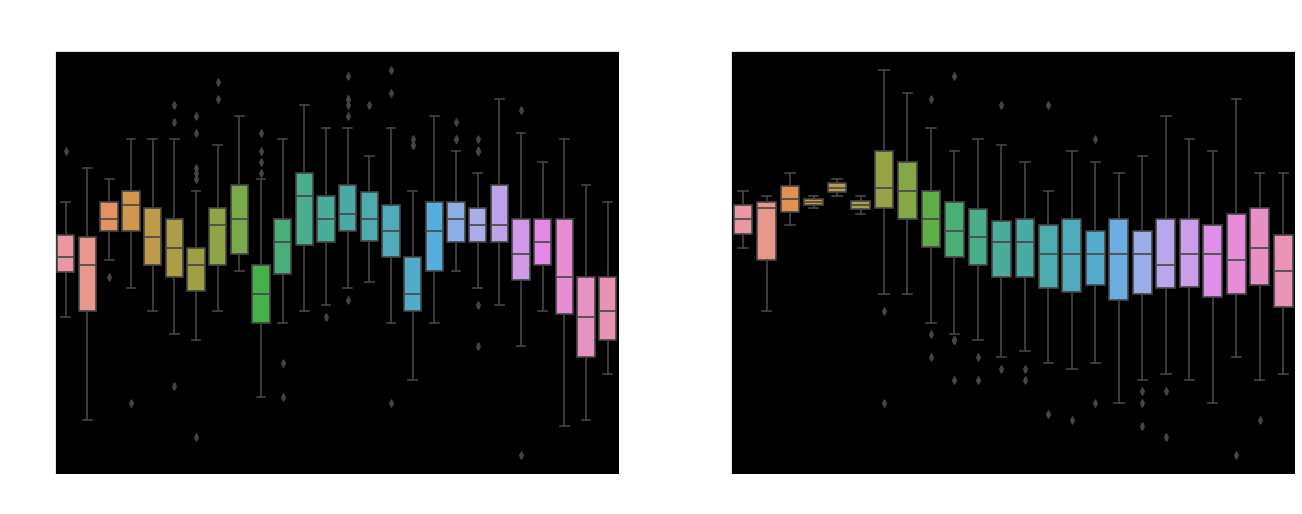

In [137]:
#Box plot of daily based on week of the year

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='yearweek', y='acceleration', data=df_hour, ax=axes[0])
sns.boxplot(x='hour', y='acceleration', data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :])

# Set Title
axes[0].set_title('Week-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

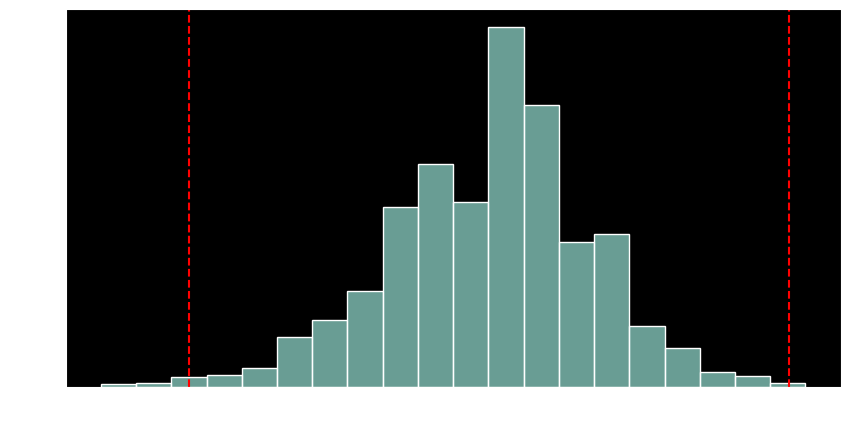

In [138]:
#Histogram with 3 standard deviations
plt.figure(figsize=(10,5), dpi=100)
# plt.hist(df_hour['acceleration'], bins = 20
sns.histplot(df_hour['acceleration'], bins = 20)
plt.axvline(x=df_hour['acceleration'].mean()+3*df_hour['acceleration'].std(), color='red',ls= '--')
plt.axvline(x=df_hour['acceleration'].mean()-3*df_hour['acceleration'].std(), color='red',ls= '--')
plt.show()

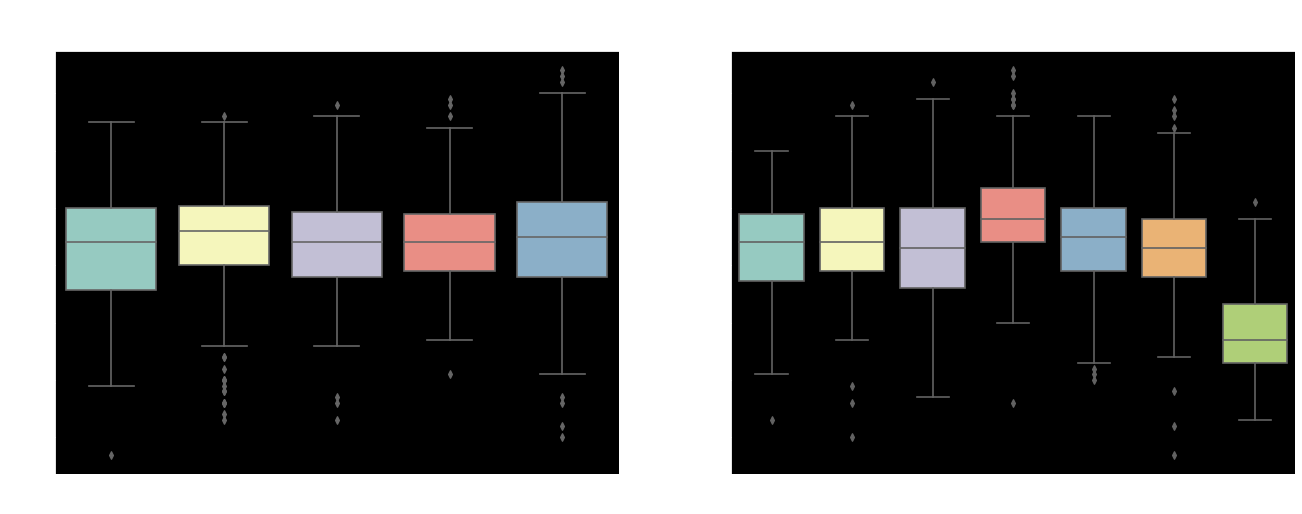

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='weekday', y='acceleration', data=df_hour, ax=axes[0])
sns.boxplot(x='month', y='acceleration', data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :])

# Set Title
axes[0].set_title('weekday Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

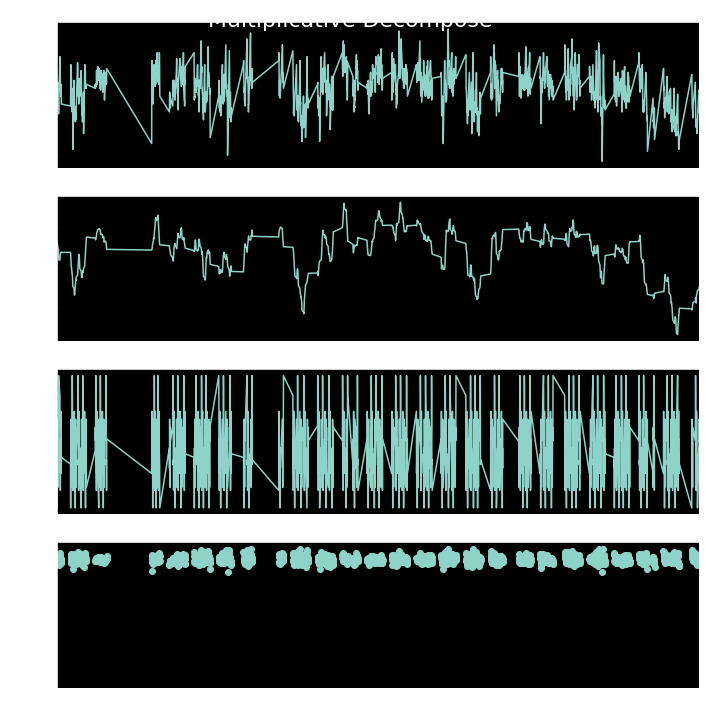

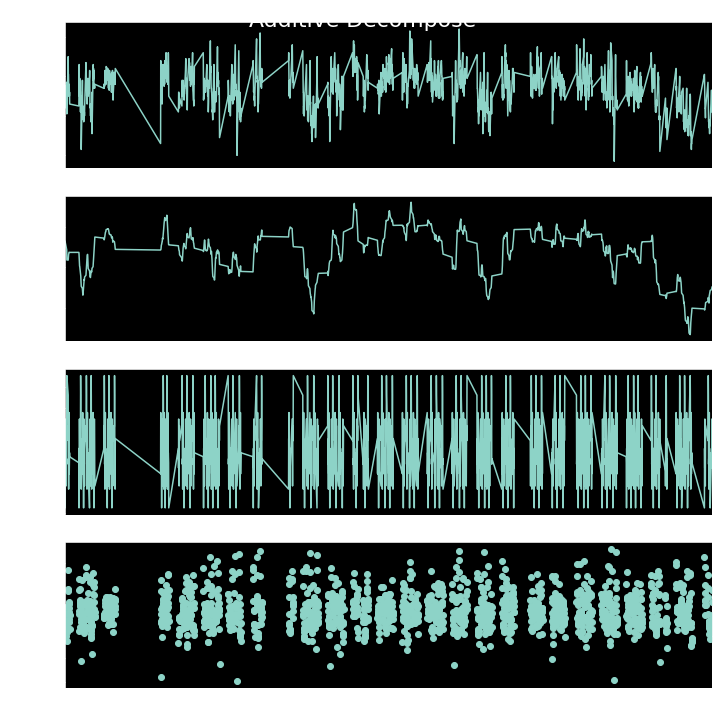

In [140]:
#Lets do some seasonality calculation adn division, we can start with additive time series
# Value = Base Level + Trend + Seasonality + Error

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_hour['acceleration'], model='multiplicative', extrapolate_trend='freq', period=24)

# Additive Decomposition
result_add = seasonal_decompose(df_hour['acceleration'], model='additive', extrapolate_trend='freq', period=24)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [141]:
result = adfuller(df_hour.acceleration.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_hour.acceleration.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.906213013473227
p-value: 3.391613007292282e-05
Critial Values:
   1%, -3.4343880265995215
Critial Values:
   5%, -2.8633235546096194
Critial Values:
   10%, -2.56771952639493

KPSS Statistic: 0.607350
p-value: 0.021968
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


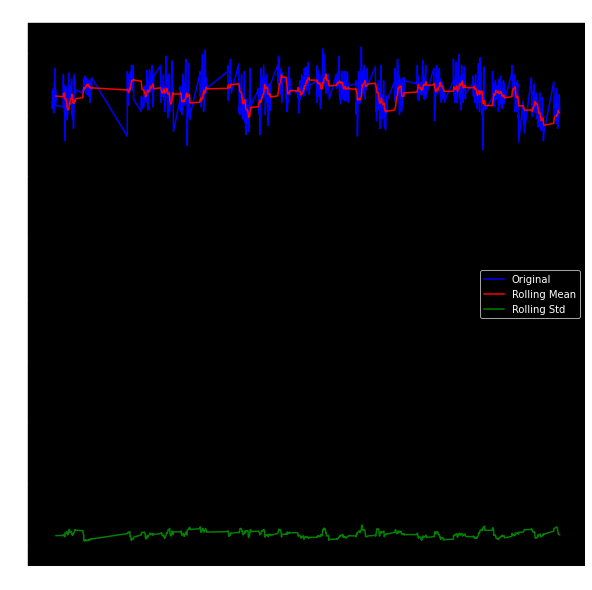

Results of Dickey-Fuller Test:


Test Statistic                   -4.906213
p-value                           0.000034
#Lags Used                       15.000000
Number of Observations Used    1622.000000
Critical Value (1%)              -3.434388
Critical Value (5%)              -2.863324
Critical Value (10%)             -2.567720
dtype: float64

In [165]:
#Determing rolling statistics to check for stationarity
rolmean = df_hour['acceleration'].rolling(24).mean()
rolstd = df_hour['acceleration'].rolling(24).std()
#Plot rolling statistics:
plt.plot(df_hour['acceleration'], color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_hour['acceleration'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

In [176]:
smooth_df_hour=df_hour['acceleration']-rolmean
smooth_df_hour.dropna(inplace=True)
smooth_df_hour


Time
2021-12-10 16:00:00   -0.302083
2021-12-13 06:00:00   -0.331250
2021-12-13 07:00:00    0.002083
2021-12-13 08:00:00    0.666667
2021-12-13 09:00:00    0.335417
                         ...   
2022-06-08 21:00:00   -0.231250
2022-06-09 06:00:00    0.579167
2022-06-09 07:00:00    0.333333
2022-06-09 08:00:00    0.141667
2022-06-09 09:00:00    0.045833
Name: acceleration, Length: 1615, dtype: float64

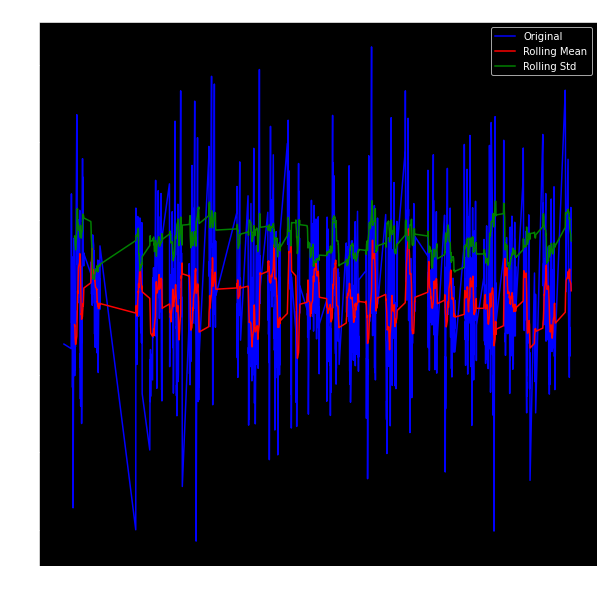

Results of Dickey-Fuller Test:


Test Statistic                -1.174391e+01
p-value                        1.254636e-21
#Lags Used                     2.000000e+01
Number of Observations Used    1.594000e+03
Critical Value (1%)           -3.434459e+00
Critical Value (5%)           -2.863355e+00
Critical Value (10%)          -2.567736e+00
dtype: float64

In [177]:
#Determing rolling statistics to check for stationarity
rolmean = smooth_df_hour.rolling(24).mean()
rolstd = smooth_df_hour.rolling(24).std()
#Plot rolling statistics:
plt.plot(smooth_df_hour, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(smooth_df_hour, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

In [ ]:
#Left it here

In [142]:
#Try using the trend af my series
df_acceleration=result_mul.trend
df_acceleration

Time
2021-12-09 09:00:00    14.822723
2021-12-09 10:00:00    14.813068
2021-12-09 11:00:00    14.803413
2021-12-09 12:00:00    14.793759
2021-12-09 13:00:00    14.784104
                         ...    
2022-06-08 21:00:00    14.212742
2022-06-09 06:00:00    14.223145
2022-06-09 07:00:00    14.233548
2022-06-09 08:00:00    14.243952
2022-06-09 09:00:00    14.254355
Name: trend, Length: 1638, dtype: float64

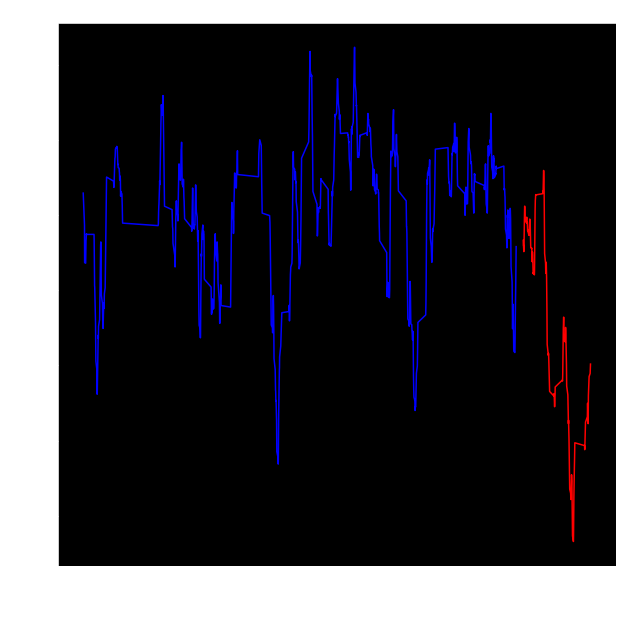

In [152]:
train = df_acceleration[df_acceleration.index < pd.to_datetime("2022-05-15", format='%Y-%m-%d')]
test = df_acceleration[df_acceleration.index >= pd.to_datetime("2022-05-15", format='%Y-%m-%d')]

plt.plot(train ,color = "blue")
plt.plot(test, color = "red")
plt.ylabel('df_acceleration Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for df_acceleration Data")
plt.show()

In [153]:
train

Time
2021-12-09 09:00:00    14.822723
2021-12-09 10:00:00    14.813068
2021-12-09 11:00:00    14.803413
2021-12-09 12:00:00    14.793759
2021-12-09 13:00:00    14.784104
                         ...    
2022-05-13 13:00:00    14.507292
2022-05-13 14:00:00    14.547917
2022-05-13 15:00:00    14.577083
2022-05-13 16:00:00    14.595833
2022-05-13 17:00:00    14.644792
Name: trend, Length: 1391, dtype: float64

In [161]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y=df_hour['acceleration']
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

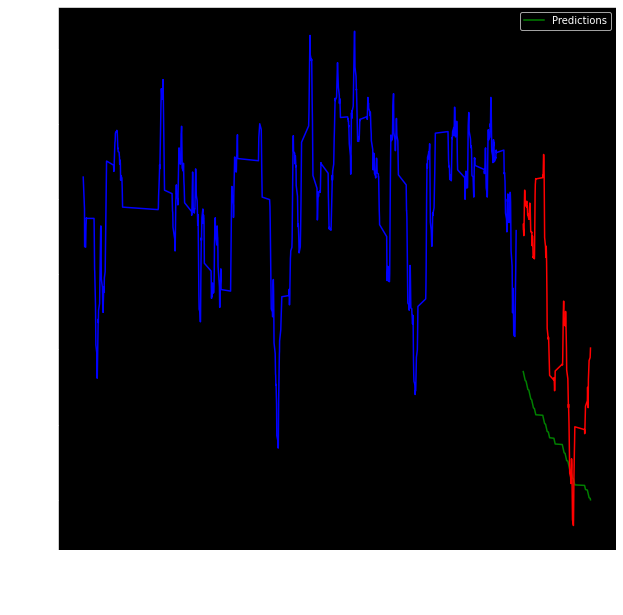

In [162]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(train ,color = "blue")
plt.plot(test, color = "red")
plt.ylabel('df_acceleration Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

In [156]:
from statsmodels.tsa.arima.model import ARIMA

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE:  0.42977049863368433


c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


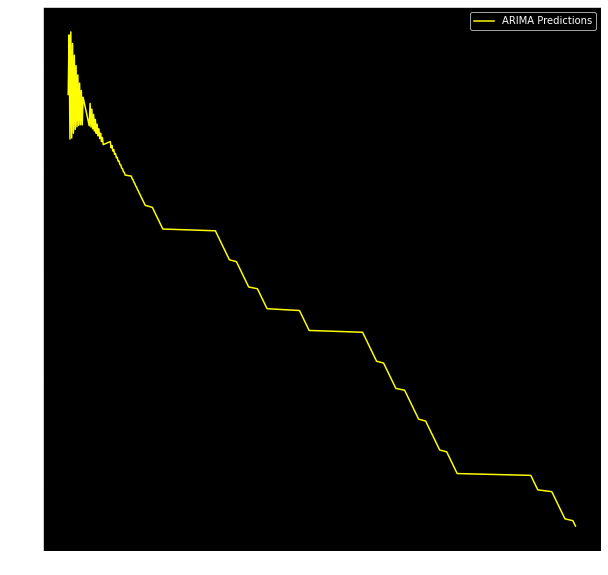

In [158]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\joses\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge

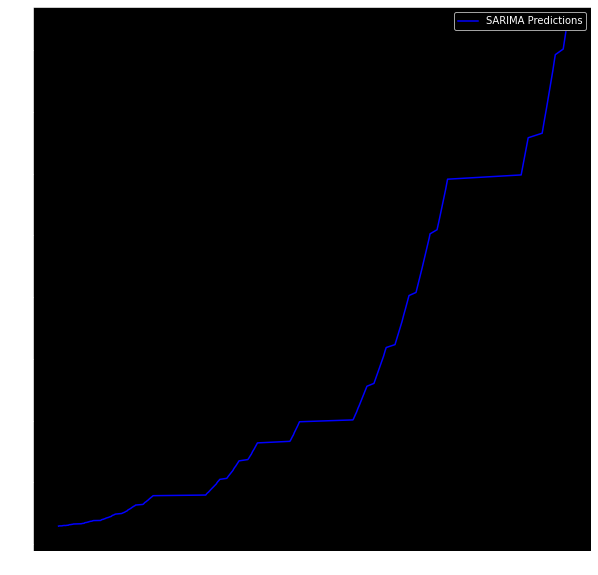

In [159]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [166]:
# Do test but with day values
df_day = df.resample('d').median()
df_day['weekday'] = [d.strftime('%a') for d in df_day.index]
df_day['day'] = [d.strftime('%H') for d in df_day.index]
df_day['yearweek'] = [d.strftime('%W') for d in df_day.index]
df_day['month'] = [d.strftime('%b') for d in df_day.index]
df_day['yearday'] = [d.strftime('%j') for d in df_day.index]
df_day['year'] = [d.strftime('%Y') for d in df_day.index]
df_day['day']=df_day['day'].astype(int)

In [170]:
df_day['acceleration']

Time
2021-12-09    14.3
2021-12-10     0.2
2021-12-11     0.2
2021-12-12     0.1
2021-12-13    14.0
              ... 
2022-06-05     0.2
2022-06-06     0.2
2022-06-07     0.2
2022-06-08    13.4
2022-06-09     0.2
Freq: D, Name: acceleration, Length: 183, dtype: float64

In [171]:
df_day_filtered=df_day[df_day['acceleration']>12]

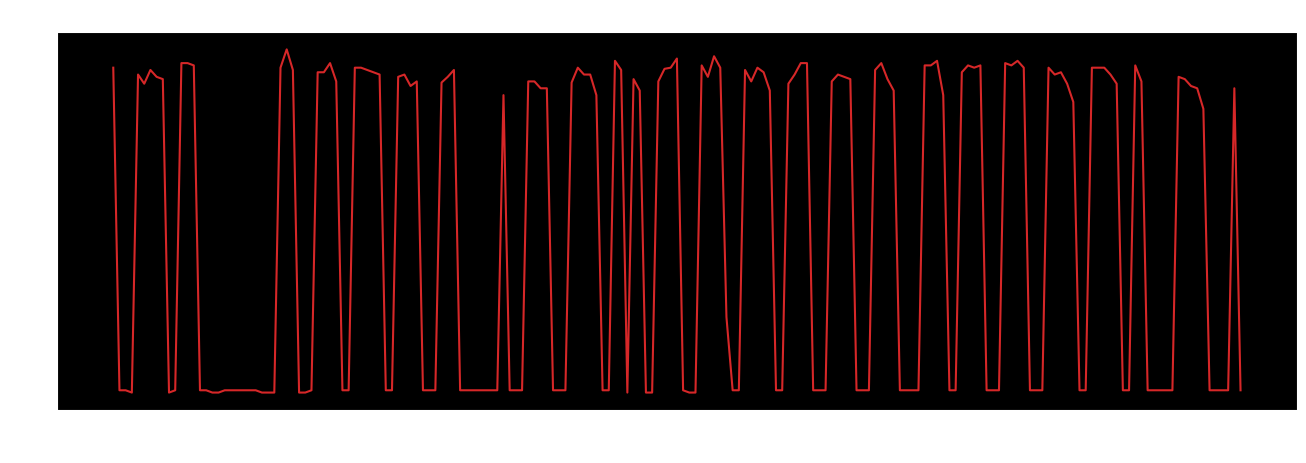

In [168]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_day.index, df_day['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

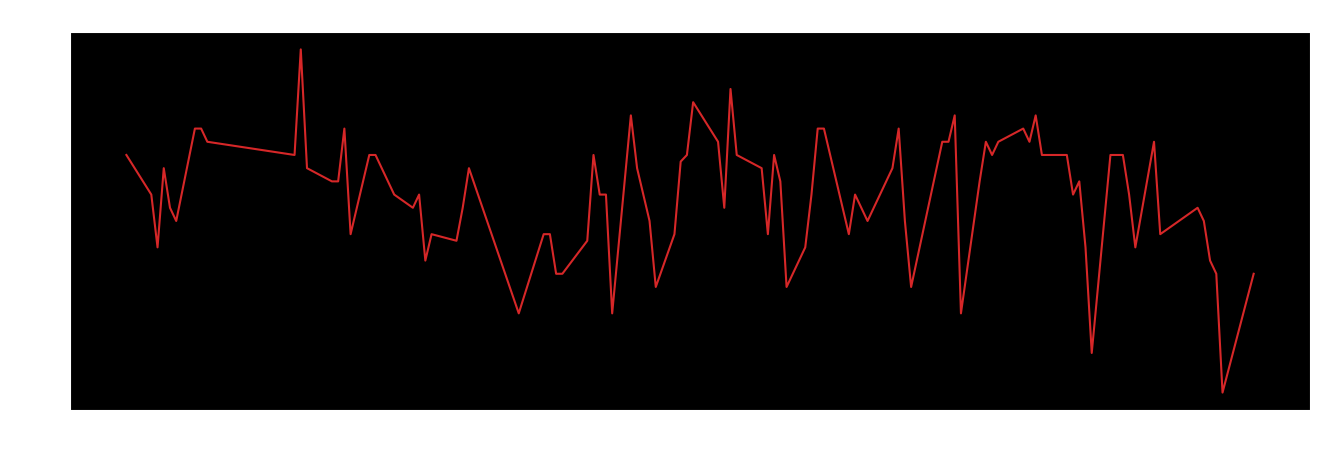

In [172]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_day_filtered.index, df_day_filtered['acceleration'], color='tab:red')
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title='acceleration', xlabel='date', ylabel='m/s2')
plt.show()

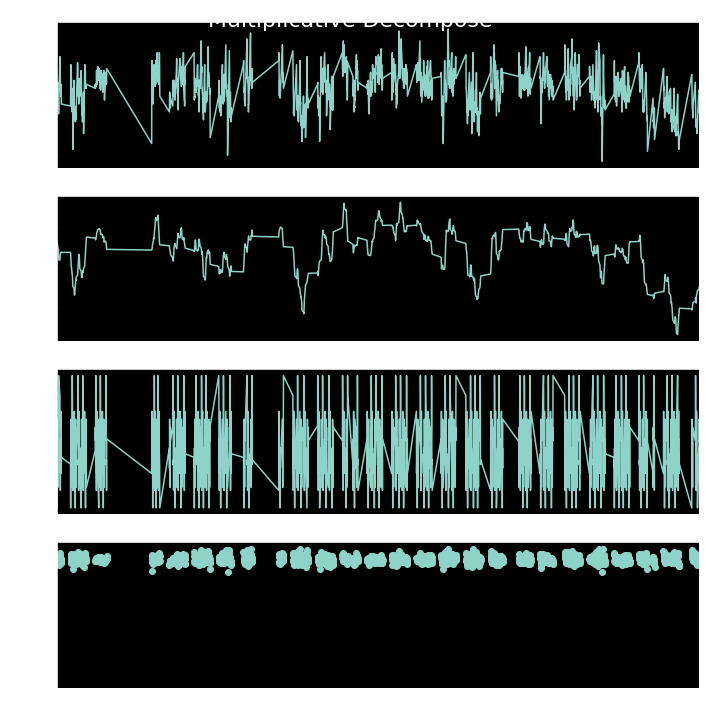

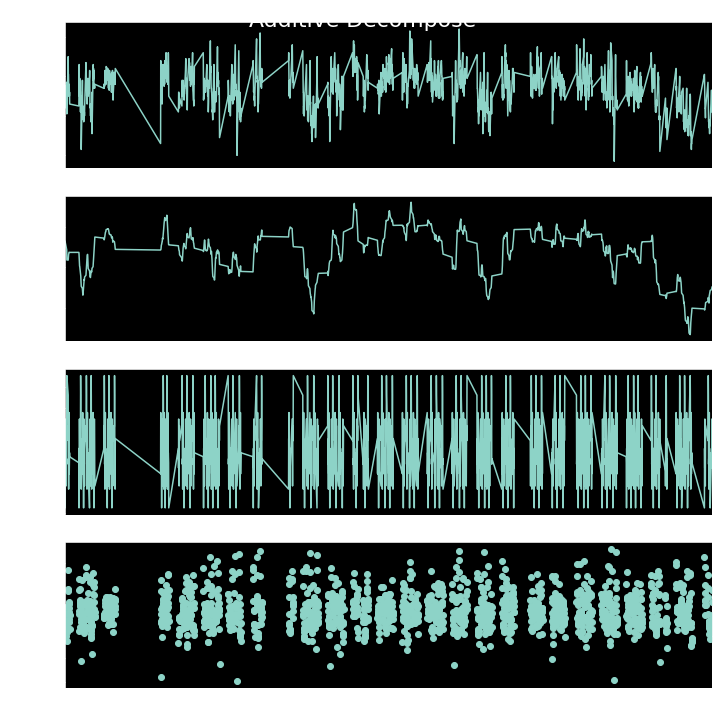

In [169]:
#Lets do some seasonality calculation adn division, we can start with additive time series
# Value = Base Level + Trend + Seasonality + Error

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_hour['acceleration'], model='multiplicative', extrapolate_trend='freq', period=24)

# Additive Decomposition
result_add = seasonal_decompose(df_hour['acceleration'], model='additive', extrapolate_trend='freq', period=24)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()